# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

**Заказчику важны**:

- качество предсказания;
- скорость предсказания;
- время обучения.

**Технические требования заказчика:**
- Для оценки качества моделей применять метрику RMSE.
- Значение метрики RMSE должно быть меньше 2500.
- Использовать в проекте библиотеку LightGBM и другие модели градиентного бустинга.

## План по выполнению проекта
    1. Загрузить и подготовить данные.
    2. Обучить разные модели с различными гиперпараметрами.
    3. Проанализировать скорость работы и качество моделей. 

## Описание данных
Данные находятся в файле /datasets/autos.csv.

    Признаки
        DateCrawled — дата скачивания анкеты из базы
        VehicleType — тип автомобильного кузова
        RegistrationYear — год регистрации автомобиля
        Gearbox — тип коробки передач
        Power — мощность (л. с.)
        Model — модель автомобиля
        Kilometer — пробег (км)
        RegistrationMonth — месяц регистрации автомобиля
        FuelType — тип топлива
        Brand — марка автомобиля
        NotRepaired — была машина в ремонте или нет
        DateCreated — дата создания анкеты
        NumberOfPictures — количество фотографий автомобиля
        PostalCode — почтовый индекс владельца анкеты (пользователя)
        LastSeen — дата последней активности пользователя
        
    Целевой признак
        Price — цена (евро)

## Шаг №1. Подготовка данных

In [1]:
# импортируем библиотеки 
import os
import math
import time
import itertools 
import urllib.request
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

!pip install lightgbm -U
import lightgbm as lgb
from lightgbm import LGBMRegressor

!pip install catboost -U
from catboost import CatBoostRegressor

In [2]:
class DataScience:

    def path_to_files(self, path, link):
        Path('datasets').mkdir(parents=True, exist_ok=True)
        def get_file(file_name, url):
            if not os.path.exists(file_name):
                print(file_name, 'файл не найден, будет загружен из сети')
                _ = urllib.request.urlretrieve(url, file_name)
        urls = {
            'dataset': (path, link)
        }
        [get_file(*urls[k]) for k in urls]
        data = pd.read_csv(urls['dataset'][0])
        return data


    def corr_diagram(self, x):
        plt.figure(figsize=(12, 10), dpi=80)
        sns.heatmap(x.corr(), xticklabels=x.corr().columns, yticklabels=x.corr().columns, cmap='RdYlGn', center=0,
                    annot=True)
        plt.title('Диаграмма корреляции', fontsize=22)
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.show()

    def clean_dataset(self, df):
        assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
        df.dropna(inplace=True)
        indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)

        return df[indices_to_keep].astype(np.float64)

    def missing_zero_values_table(self, df):
        zero_val = (df == 0.00).astype(int).sum(axis=0)
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mz_table = pd.concat([zero_val, mis_val, mis_val_percent], axis=1)
        mz_table = mz_table.rename(
            columns={0: 'Zero Values', 1: 'Missing Values', 2: '% of Total Values'})
        mz_table['Total Zero and Missing Values'] = mz_table['Zero Values'] + mz_table['Missing Values']
        mz_table['% Total Zero and Missing Values'] = 100 * mz_table['Total Zero and Missing Values'] / len(df)
        mz_table['Data Type'] = df.dtypes
        mz_table = mz_table[mz_table.iloc[:, 1] != 0].sort_values('% of Total Values', ascending=False).round(1)
        print("Your selected dataframe has " + str(df.shape[1]) + " columns and " + str(df.shape[0]) + " Rows.\n"
           "There are " + str(mz_table.shape[0]) +
              " columns that have missing values.") 
        print("Number of rows that have at least one NaN", df.isnull().any(axis=1).sum(), " or ",  f"{df.isnull().any(axis=1).sum() / len(df):.1%}")        
        return mz_table

    def fill_with_mode(self, column, column1, column2):
        df[column] = df.groupby([column1, column2])[column].transform(lambda x: x.fillna((x.mode()[0] if not x.mode().empty else "Empty")))       


In [3]:
# присвоим переменной ds созданный класс DataScience
ds = DataScience()

In [4]:
# загрузим файл autos.csv в переменную df

try:
    df = ds.path_to_files('e:/Яндекс.Практикум/Спринт 14 Численные методы/datasets/autos.csv','https://code.s3.yandex.net/datasets/autos.csv')
except:
    df = pd.read_csv("/datasets/autos.csv")

In [5]:
# откроем датафрейм
display(df.head(10))

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


In [6]:
# изучим общую инфмормацию о датасете
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

None

In [7]:
# взглянем на статистики
display(df.describe())

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [8]:
# прменим метод missing_zero_values_table класса DataScience, чтобы получить информацию по количеству пустых значений
ds.missing_zero_values_table(df) 

Your selected dataframe has 16 columns and 354369 Rows.
There are 5 columns that have missing values.
Number of rows that have at least one NaN 108555  or  30.6%


,Zero Values,Missing Values,% of Total Values,Total Zero and Missing Values,% Total Zero and Missing Values,Data Type
NotRepaired,0,71154,20.1,71154,20.1,object
VehicleType,0,37490,10.6,37490,10.6,object
FuelType,0,32895,9.3,32895,9.3,object
Gearbox,0,19833,5.6,19833,5.6,object
Model,0,19705,5.6,19705,5.6,object


Датафрейм содержит более 30% строк с пропущенными значениями - удалять такой массив данных нецелесообразно!

In [9]:
# посчитаем количество дубликатов в датасете
df.duplicated().sum()

4

In [10]:
# сделаем замену текстовых значений в признаке 'NotRepaired': "yes" заменим на 1 , "no" на 0
df['NotRepaired'] = df['NotRepaired'].map({'yes':1, 'no':0})

In [11]:
# посчитаем количество уникальных значений в категориальных признаках
categorical = ['Brand','Model','VehicleType','Gearbox','FuelType']
numerical_features_names = df.select_dtypes(include=['int64'])
df[categorical].nunique()

Brand           40
Model          250
VehicleType      8
Gearbox          2
FuelType         7
dtype: int64

2700.0

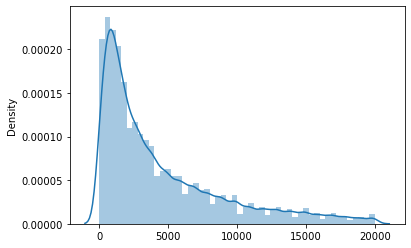

In [12]:
# посмотрим на распределение целевого признака
sns.distplot(df.Price.values)
np.median(df.Price.values)

In [13]:
# удалим из датафрейма строки с ценой, равной 0 или 1 Евро. 
# даже несмотря на то, что такая цена может быть в реальности (например, 
# авто на металлолом), для нашего исследования такие авто не несут практической значимости: цену в 0-1 Евро предсказать точно 
# крайне сложно (кто-то сдает на металлолом, а кто-то выставит как раритет один и тот же автомобиль по хорошей цене!)
print("Число строк с ценой авто не более 1 Евро  = ", df[df['Price']<=1].shape[0])
df = df[df['Price']>1]
print("Данные строки будут удалены из датафрейма")

Число строк с ценой авто не более 1 Евро  =  11961
Данные строки будут удалены из датафрейма


In [14]:
# удалим из датафрейма автомобили с мощностью больше 4600 л.с., потому что таких автомобилей не бывает 
# к сведению: самый мощный авто на 2022 год - БЕЛАЗ (4600 л.с.) 
# https://www.arenda-auto.ru/news/samye-moshchnye-avtomobili-v-mire.html 
print("Число строк с авто мощностью свыше 4600 л.с. = ", df[df['Power']>4600].shape[0])
df = df[df['Power']<=4600]
print("Данные строки будут удалены из датафрейма")

Число строк с авто мощностью свыше 4600 л.с. =  80
Данные строки будут удалены из датафрейма


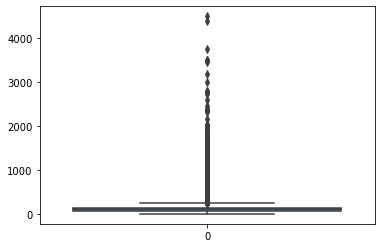

In [15]:
# построим "ящик с усами" по распределению мощностей автомобилей
sns.boxplot(data=df['Power']);

Год регистрации авто, минимальный 1000
Год регистрации авто, максимальный 9999


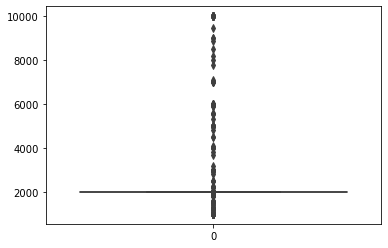

In [16]:
# проверим столбец с датой регистрации авто, для этого
# построим "ящик с усами" по распределению годов регистрации автомобилей
sns.boxplot(data=df['RegistrationYear']);
print("Год регистрации авто, минимальный", df['RegistrationYear'].min())
print("Год регистрации авто, максимальный", df['RegistrationYear'].max())

Как видно на графике, присутствует достаточно много выбросов и аномалий, с которыми необходимо разобраться дальше!

In [17]:
# добавим в df столбец 'YearCrawled', в котором будет год загрузки анкеты  
df['DateCrawled'] = pd.to_datetime(df['DateCrawled'], format='%Y-%m-%d %H:%M')
df['YearCrawled'] = df['DateCrawled'].dt.year
cars_up_to_del = df['YearCrawled'].shape[0]
print("Количество объектов ДО удаления аномалий по году регистрации авто", cars_up_to_del)

# оставим в df только те объекты, по которым df['RegistrationYear'] <= df['YearCrawled'], т.е. регистрация 
# авто не позже, чем дата создания анкеты 
df = df[df['RegistrationYear'] <= df['YearCrawled']]
cars_after_del = df['YearCrawled'].shape[0]
print("Количество объектов ПОСЛЕ удаления аномалий по году регистрации авто", cars_after_del)
print("Процент удаленных строк = ", f"{ (cars_up_to_del - cars_after_del) / cars_up_to_del:.1%}")

Количество объектов ДО удаления аномалий по году регистрации авто 342328
Количество объектов ПОСЛЕ удаления аномалий по году регистрации авто 328622
Процент удаленных строк =  4.0%


In [18]:
# удалим из датафрейма объекты с годом регистрации менее чем 1886 год, т.к. именно в этом году, а точнее
# 29 января 1886 года Карл Фридрих Бенц (Karl Friedrich Benz) представил миру свой первый автомобиль. 
# Эта моторизированная повозка могла развивать скорость до 18 км/ч.
# Возможно, следовало бы оставить в исследовании только авто, выпущенные после 1980 года (примерно), но интересно посмотреть, 
# как отработает модель с предсказанием цены на коллекционные и ретро автомобили
print("Число строк с автомобилями старше 1886 года  = ", df[df['RegistrationYear']<1886].shape[0])
df = df[df['Price']>=1886]
print("Данные строки будут удалены из датафрейма")

Число строк с автомобилями старше 1886 года  =  49
Данные строки будут удалены из датафрейма


In [19]:
# удалим из датафрейма строки с ценой, равной 0 или 1 Евро. 
# даже несмотря на то, что такая цена может быть в реальности (например, 
# авто на металлолом), для нашего исследования такие авто не несут практической значимости: цену в 0-1 Евро предсказать точно 
# крайне сложно (кто-то сдает на металлолом, а кто-то выставит как раритет один и тот же автомобиль по хорошей цене!)
#print("Число строк с ценой авто не более 1 Евро  = ", df[df['Price']<=1].shape[0])
#df = df[df['Price']>1]

In [20]:
#Удалим столбцы которые нам не понадобятся
df=df.drop(['DateCreated', 'DateCrawled', 'PostalCode','LastSeen','NumberOfPictures'], axis=1)
df.head(5)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,YearCrawled
1,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,1.0,2016
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,0.0,2016
6,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,0.0,2016
8,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016


In [21]:
# пустые значения в NotRepaired заменим на 0, так как скорее всего пользователи, 
# заполнявшие форму, в графе о починке авто ничего не ставили, если авто не чинилось
df['NotRepaired'] = df['NotRepaired'].fillna(0)
df['NotRepaired'] = df['NotRepaired'].astype('int64')

In [22]:
# на основе имеющихся данных заменим пустые значения методом fill_with_mode класса DataScience
ds.fill_with_mode('Model','Brand','RegistrationYear')
ds.fill_with_mode('VehicleType','Brand','Model')
ds.fill_with_mode('FuelType','Brand','Model')

In [23]:
#Заменим Empty на nan
df = df.replace('Empty',np.nan)

# посмотрим на остаток пропущенных значений в датафрейме
ds.missing_zero_values_table(df)  # строк с пропущенными данными уже всего лишь 6,2 %, их можно удалить!

Your selected dataframe has 12 columns and 207761 Rows.
There are 4 columns that have missing values.
Number of rows that have at least one NaN 8337  or  4.0%


,Zero Values,Missing Values,% of Total Values,Total Zero and Missing Values,% Total Zero and Missing Values,Data Type
Gearbox,0,6609,3.2,6609,3.2,object
Model,0,1950,0.9,1950,0.9,object
VehicleType,0,4,0.0,4,0.0,object
FuelType,0,1,0.0,1,0.0,object


In [24]:
# удалим nan значения и дубликаты
df = df.dropna()
df = df.drop_duplicates()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 180434 entries, 1 to 354368
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              180434 non-null  int64 
 1   VehicleType        180434 non-null  object
 2   RegistrationYear   180434 non-null  int64 
 3   Gearbox            180434 non-null  object
 4   Power              180434 non-null  int64 
 5   Model              180434 non-null  object
 6   Kilometer          180434 non-null  int64 
 7   RegistrationMonth  180434 non-null  int64 
 8   FuelType           180434 non-null  object
 9   Brand              180434 non-null  object
 10  NotRepaired        180434 non-null  int64 
 11  YearCrawled        180434 non-null  int64 
dtypes: int64(7), object(5)
memory usage: 17.9+ MB


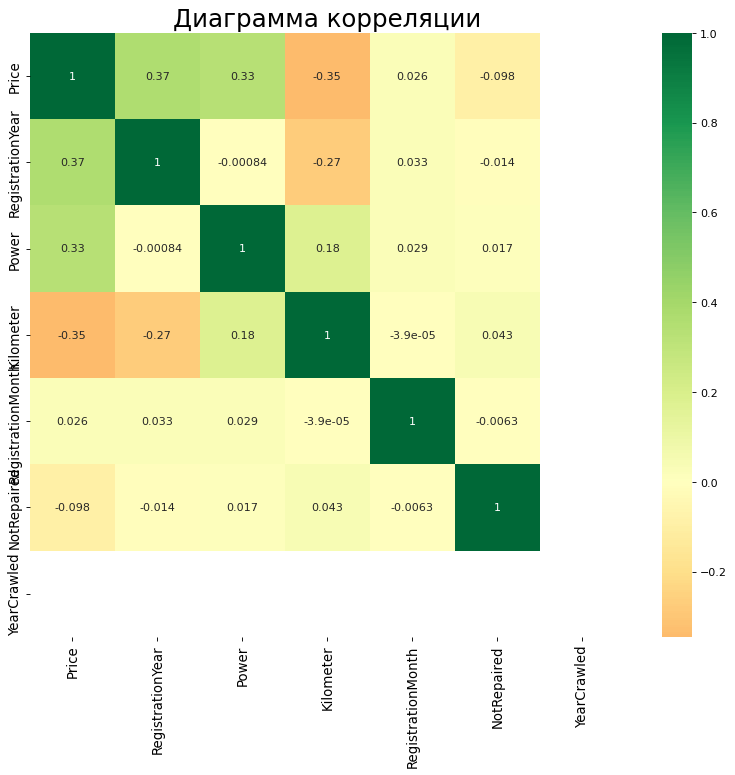

In [25]:
# нарисуем диаграмму корреляций
ds.corr_diagram(df)

## Вывод по "Шаг №1. Подготовка данных"
    Проанализировали отдельные столбцы на выбросы (провели срез в признаке Power до 4600 лошадинных сил, т.к. больших мощностей у автомобилей не бывает).
    Заменили пустые значения в столбцах 'VehicleType', 'FuelType', 'Model' на имеющиеся значения с похожими значениями.
    Удалили дубликаты и пустые значения.
    
    Таким образом, данные подготовлены для работы с моделями!

## Шаг №2. Обучение моделей

### Шаг №2.0. Подготовка признаков и выборок 

In [26]:
# применим технику прямого кодирования, чтобы преобразовать категориальные признаки в численные.
df_ohe = pd.get_dummies(df, drop_first=True)

In [27]:
# признаки для обучения модели линейной регрессии
features_lr = df_ohe.drop(['Price'], axis = 1)
target_lr = df_ohe['Price']

In [28]:
# преобразуем столбцы с категориальными признаки в тип данных category
categorical = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']
for col in categorical:
    df[col] = df[col].astype('category')

In [29]:
# признаки для обучения моделей CBR и LGBM
features = df.drop(['Price'], axis = 1)
target = df['Price']

In [30]:
# разделим датафрейм на выборки для линейной регрессии
features_train_lr, features_test_lr, target_train_lr, target_test_lr = train_test_split(features_lr, target_lr, test_size=.25, random_state=12345)

In [31]:
# cтандартизируем признаки после разделения на обучающую и тестовую выборки с помощью StandardScaler для линейной регрессии
scaler = StandardScaler()
numeric = ['RegistrationYear','Power','Kilometer']
scaler.fit(features_train_lr[numeric])
features_train_lr[numeric] = scaler.transform(features_train_lr[numeric])
features_test_lr[numeric] = scaler.transform(features_test_lr[numeric])

In [32]:
# разделим датафрейм на выборки для CatBoostRegressor (разработка Яндекс) и LightGBM (разработка MicroSoft)
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=.25, random_state=12345)

In [33]:
# cтандартизируем признаки после разделения на обучающую и тестовую выборки 
# с помощью StandardScaler для CatBoostRegressor и LightGBM
scaler = StandardScaler()
numeric = ['RegistrationYear','Power','Kilometer']
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

In [34]:
#напишем формулу для получения значения метрики RMSE
def rmse (target, predictions):
    mse = mean_squared_error(target, predictions)
    rmse = mse ** 0.5
    return rmse

### Шаг №2.1. LinearRegression

Обучим, получим предсказания и проверим качество модели LinearRegression с замером времени

In [35]:
lr_model = LinearRegression()

In [36]:
%%time
lr_model.fit(features_train_lr, target_train_lr)

Wall time: 2.5 s


LinearRegression()

In [37]:
features_test_lr.head()

,RegistrationYear,Power,Kilometer,RegistrationMonth,NotRepaired,YearCrawled,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,...,Brand_saab,Brand_seat,Brand_skoda,Brand_smart,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo
72865,0.966362,-0.629858,-1.318157,10,0,2016,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
91552,-0.262633,-0.303875,0.698173,12,0,2016,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
202120,0.198240,1.411083,0.698173,9,0,2016,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
280751,0.044616,1.269351,0.698173,2,0,2016,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
338077,-2.106126,-0.502299,0.698173,3,0,2016,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0


In [38]:
target_test_lr.min(), target_test_lr.max()

(1887, 20000)

In [39]:
%%time
predicted_lr = lr_model.predict(features_test_lr)

Wall time: 103 ms


In [40]:
predicted_lr.min()

-13383936.0

In [41]:
rmse_lr = round(rmse(target_test_lr, predicted_lr))
print(rmse_lr)

303847763


In [42]:
features_train_lr.shape

(135325, 305)

In [43]:
target_train_lr.shape

(135325,)

In [44]:
features_test_lr.shape

(45109, 305)

In [45]:
target_test_lr.shape

(45109,)

### Шаг №2.2. CatBoostRegressor

 Обучим, получим предсказания и проверим качество модели CatBoostRegressor с замером времени. Официальный сайт - https://catboost.ai/ 
 Ознакомительная статья по данной модели размещена по ссылке https://itnan.ru/post.php?c=1&p=594077
    
    CatBoost – библиотека, которая была разработана Яндексом в 2017 году, представляет разновидность семейства алгоритмов Boosting и является усовершенствованной реализацией Gradient Boosting Decision Trees (GBDT). CatBoost имеет поддержку категориальных переменных и обеспечивает высокую точность. Стоит сказать, что CatBoost решает проблему смещения градиента (Gradient Bias) и смещения предсказания (Prediction Shift), это позволяет уменьшить вероятность переобучения и повысить точность алгоритма.

In [46]:
#построим модель CBR и исследуем её работу с различными значениями гиперпараметра iterations с помощью кросс-валидации
for iteration in range(10, 151, 30):
    cat_model = CatBoostRegressor(loss_function="RMSE", iterations=iteration, depth=10, verbose=10, cat_features=categorical)
    cat_cv = cross_val_score(cat_model, features_train, target_train, cv=2)
    print("Score при iterations =", iteration, ":", cat_cv)
    print("Score mean =", sum(cat_cv)/len(cat_cv))
    print()

Learning rate set to 0.5
0:	learn: 3265.0478005	total: 245ms	remaining: 2.2s
9:	learn: 1947.4633662	total: 1.1s	remaining: 0us
Learning rate set to 0.5
0:	learn: 3250.3719267	total: 92.7ms	remaining: 834ms
9:	learn: 1950.5761485	total: 902ms	remaining: 0us
Score при iterations = 10 : [0.80150758 0.80491302]
Score mean = 0.8032103008833793

Learning rate set to 0.5
0:	learn: 3265.0478005	total: 88.7ms	remaining: 3.46s
10:	learn: 1935.8134777	total: 938ms	remaining: 2.47s
20:	learn: 1814.8496989	total: 1.77s	remaining: 1.6s
30:	learn: 1752.9888997	total: 2.62s	remaining: 760ms
39:	learn: 1715.0047061	total: 3.36s	remaining: 0us
Learning rate set to 0.5
0:	learn: 3250.3719267	total: 87ms	remaining: 3.39s
10:	learn: 1941.3509130	total: 899ms	remaining: 2.37s
20:	learn: 1821.2115584	total: 1.75s	remaining: 1.58s
30:	learn: 1751.4569584	total: 2.62s	remaining: 759ms
39:	learn: 1703.7879650	total: 3.4s	remaining: 0us
Score при iterations = 40 : [0.82560047 0.82940676]
Score mean = 0.827503618

In [47]:
#исследуем работу модели с различными значениями гиперпараметра depth
for depth in range(5, 16, 2):
    cat_model = CatBoostRegressor(loss_function="RMSE", iterations=20, depth=depth, verbose=5, cat_features=categorical)
    cat_cv = cross_val_score(cat_model, features_train, target_train, cv=2)
    print("Score при depth =", depth, ":", cat_cv)
    print("Score mean =", sum(cat_cv)/len(cat_cv))
    print()

Learning rate set to 0.5
0:	learn: 3441.3905013	total: 37.4ms	remaining: 710ms
5:	learn: 2297.7663429	total: 232ms	remaining: 542ms
10:	learn: 2150.1555078	total: 409ms	remaining: 334ms
15:	learn: 2082.7339149	total: 589ms	remaining: 147ms
19:	learn: 2051.8774049	total: 734ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 3420.0206233	total: 38.1ms	remaining: 724ms
5:	learn: 2288.3424798	total: 247ms	remaining: 576ms
10:	learn: 2147.4084696	total: 442ms	remaining: 361ms
15:	learn: 2086.8486769	total: 645ms	remaining: 161ms
19:	learn: 2057.1049487	total: 810ms	remaining: 0us
Score при depth = 5 : [0.78933797 0.79191096]
Score mean = 0.79062446296962

Learning rate set to 0.5
0:	learn: 3352.4842420	total: 55.5ms	remaining: 1.05s
5:	learn: 2190.7086703	total: 335ms	remaining: 782ms
10:	learn: 2053.6869074	total: 625ms	remaining: 511ms
15:	learn: 1989.1497201	total: 908ms	remaining: 227ms
19:	learn: 1951.8044782	total: 1.12s	remaining: 0us
Learning rate set to 0.5
0:	learn: 3344.0120664

При увеличении iterations модель сначала дает намного бОльшую точность (в 2 раза), затем увеличение точности начинает снижаться, до тех пор, пока разница не становится совсем незначительной. Следует учесть, что скорость обучения модели для нас важна так же, как и точность ее работы, поэтому выберем оптимальный вариант с числом iterations 110.

При изменении параметра depth прослеживается такая же тенденция, поэтому оптимальной глубиной будет число 15.

Измерим время обучения и работы модели со значением iterations = 110 и depth = 15.

In [48]:
cat_model_selected_options= CatBoostRegressor(loss_function="RMSE", iterations=110, depth=15, verbose=10)

In [49]:
%%time
cat_model_selected_options.fit(features_train, target_train, cat_features=categorical)

Learning rate set to 0.5
0:	learn: 3145.2231823	total: 1.08s	remaining: 1m 57s
10:	learn: 1774.7469250	total: 10.5s	remaining: 1m 34s
20:	learn: 1643.4954823	total: 19.2s	remaining: 1m 21s
30:	learn: 1541.5398211	total: 28.4s	remaining: 1m 12s
40:	learn: 1458.7631646	total: 37.8s	remaining: 1m 3s
50:	learn: 1387.6954416	total: 46.3s	remaining: 53.6s
60:	learn: 1342.0590397	total: 55.3s	remaining: 44.5s
70:	learn: 1302.7320821	total: 1m 4s	remaining: 35.3s
80:	learn: 1273.3429755	total: 1m 12s	remaining: 26s
90:	learn: 1249.1487632	total: 1m 21s	remaining: 17s
100:	learn: 1220.5857605	total: 1m 30s	remaining: 8.06s
109:	learn: 1200.5920723	total: 1m 38s	remaining: 0us
Wall time: 1min 39s


In [50]:
%%time
predicted_cat_selected_options = pd.Series(cat_model_selected_options.predict(features_test))

Wall time: 86.9 ms


In [51]:
rmse(target_test, predicted_cat_selected_options)

1824.669552151516

### Дополнительный шаг №2.2.1. CatBoostRegressor _ GridSearch

В данном разделе сделана попытка подбора наилучших гиперпараметров с помощью GridSearch. К сожалению, подбор параметров с широким диапазоном не удалось закончить ввиду времени выполнения, но на "легком наборе параметров" можно показать принцип работы GridSearch для CatBoostRegressor()

In [52]:
model_CBR = CatBoostRegressor()

parameters = {'depth'         : [15,20],
                  'learning_rate' : [0.01, 0.1],
                  'iterations'    : [110, 150],
                  'loss_function':  ['RMSE']
                 }

grid = GridSearchCV(estimator=model_CBR, param_grid = parameters, cv = 2, n_jobs=-1, scoring='neg_root_mean_squared_error')
grid.fit(features_train, target_train, cat_features=categorical)

print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n", grid.best_estimator_)
print("\n The best score across ALL searched params:\n", grid.best_score_)
print("\n The best parameters across ALL searched params:\n", grid.best_params_)

0:	learn: 4199.6236688	total: 922ms	remaining: 2m 17s
1:	learn: 3943.7233808	total: 1.76s	remaining: 2m 9s
2:	learn: 3709.2579523	total: 2.58s	remaining: 2m 6s
3:	learn: 3502.4747102	total: 3.38s	remaining: 2m 3s
4:	learn: 3321.8467802	total: 4.29s	remaining: 2m 4s
5:	learn: 3160.8417709	total: 5.22s	remaining: 2m 5s
6:	learn: 3021.8650733	total: 6.14s	remaining: 2m 5s
7:	learn: 2874.5393879	total: 7.06s	remaining: 2m 5s
8:	learn: 2749.8144347	total: 8.01s	remaining: 2m 5s
9:	learn: 2639.3304224	total: 8.93s	remaining: 2m 4s
10:	learn: 2546.7934925	total: 9.87s	remaining: 2m 4s
11:	learn: 2460.3781727	total: 10.8s	remaining: 2m 3s
12:	learn: 2388.0786025	total: 11.7s	remaining: 2m 3s
13:	learn: 2324.3211111	total: 12.6s	remaining: 2m 2s
14:	learn: 2268.9118851	total: 13.5s	remaining: 2m 1s
15:	learn: 2221.2947224	total: 14.3s	remaining: 1m 59s
16:	learn: 2180.0404938	total: 15.2s	remaining: 1m 58s
17:	learn: 2139.3277355	total: 16.1s	remaining: 1m 58s
18:	learn: 2103.7108958	total: 17s

Измерим время обучения и работы модели со значениями гиперпараметров, подобранными через GridSearchCV

In [53]:
cat_model_selected_options_grid= CatBoostRegressor(**grid.best_params_)

In [54]:
%%time
cat_model_selected_options_grid.fit(features_train, target_train, cat_features=categorical)

0:	learn: 4199.6236688	total: 973ms	remaining: 2m 24s
1:	learn: 3943.7233808	total: 1.89s	remaining: 2m 19s
2:	learn: 3709.2579523	total: 2.92s	remaining: 2m 23s
3:	learn: 3502.4747102	total: 3.87s	remaining: 2m 21s
4:	learn: 3321.8467802	total: 4.81s	remaining: 2m 19s
5:	learn: 3160.8417709	total: 5.73s	remaining: 2m 17s
6:	learn: 3021.8650733	total: 6.58s	remaining: 2m 14s
7:	learn: 2874.5393879	total: 7.42s	remaining: 2m 11s
8:	learn: 2749.8144347	total: 8.24s	remaining: 2m 9s
9:	learn: 2639.3304224	total: 9.07s	remaining: 2m 6s
10:	learn: 2546.7934925	total: 9.95s	remaining: 2m 5s
11:	learn: 2460.3781727	total: 10.8s	remaining: 2m 4s
12:	learn: 2388.0786025	total: 11.8s	remaining: 2m 4s
13:	learn: 2324.3211111	total: 12.7s	remaining: 2m 3s
14:	learn: 2268.9118851	total: 13.6s	remaining: 2m 2s
15:	learn: 2221.2947224	total: 14.5s	remaining: 2m 1s
16:	learn: 2180.0404938	total: 15.3s	remaining: 1m 59s
17:	learn: 2139.3277355	total: 16.1s	remaining: 1m 58s
18:	learn: 2103.7108958	tota

In [55]:
%%time
predicted_cat_selected_options_grid = pd.Series(cat_model_selected_options_grid.predict(features_test))

Wall time: 90.9 ms


In [56]:
rmse_cbr = round(rmse(target_test, predicted_cat_selected_options_grid))
print(rmse_cbr)

1786


### Шаг №2.3. LightGBM

Обучим, получим предсказания и проверим качество модели LightGBM с замером времени

LightGBM, сокращение от Light Gradient Boosting Machine, представляет собой бесплатную распределенную структуру повышения градиента с открытым исходным кодом для машинного обучения, первоначально разработанную Microsoft.

Официальная страница https://lightgbm.readthedocs.io/en/v3.3.2/

In [57]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'max_depth': 7, 
    'learning_rate': 0.2,
    'verbose': 0
}

In [58]:
lgbm_model = LGBMRegressor(**params)

In [59]:
%%time
lgbm_model.fit(features_train, target_train)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005379 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Wall time: 1.07 s


LGBMRegressor(learning_rate=0.2, max_depth=7, metric='rmse',
              objective='regression', verbose=0)

In [60]:
%%time
predictions_lgbm = lgbm_model.predict(features_test)

Wall time: 89.9 ms


In [61]:
rmse_lgbm = round(rmse(target_test, predictions_lgbm))
print(rmse_lgbm)

1777


## Шаг №3. Анализ моделей

Сведем полученные данные по скорости обучения (в секундах), скорости предсказания (в миллисекундах) и качеству моделей (в данном случае RMSE) в таблицу

In [62]:
# занесем время обучения моделей в переменные
train_time_lr = 2.5
train_time_cbr = 133
train_time_lgbm = 1

# занесем время предсказания моделей в переменные
work_time_lr = 103
work_time_cbr = 91
work_time_lgbm = 90

# подготовим датафрейм для анализа
models = [['LR', train_time_lr, work_time_lr, rmse_lr], 
          ['CBR', train_time_cbr, work_time_cbr, rmse_cbr], 
          ['LGB', train_time_lgbm, work_time_lgbm, rmse_lgbm]] 
    
df_model = pd.DataFrame(models, columns =['model', 'train_time, sec', 'work_time, msec', 'rmse']) 
df_model

,model,"train_time, sec","work_time, msec",rmse
0,LR,2.5,103,303847763
1,CBR,133.0,91,1786
2,LGB,1.0,90,1777


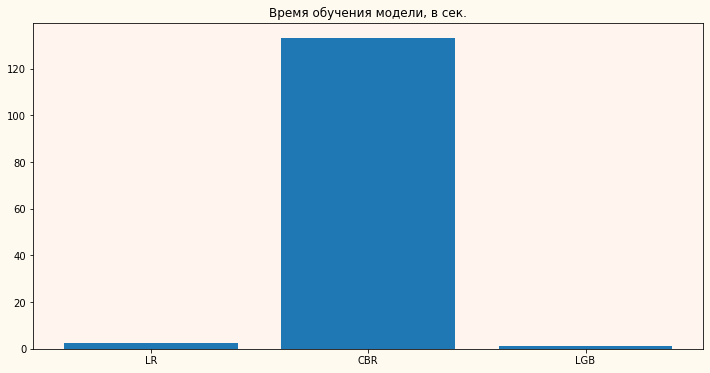

In [63]:
# представим на диаграмме данные по параметру train_time, sec

fig, ax = plt.subplots()

x = df_model['model']
y = df_model['train_time, sec']
ax.bar(x, y)

ax.set_title('Время обучения модели, в сек.')
ax.set_facecolor('seashell')
fig.set_facecolor('floralwhite')
fig.set_figwidth(12)    #  ширина Figure
fig.set_figheight(6)    #  высота Figure

plt.show()

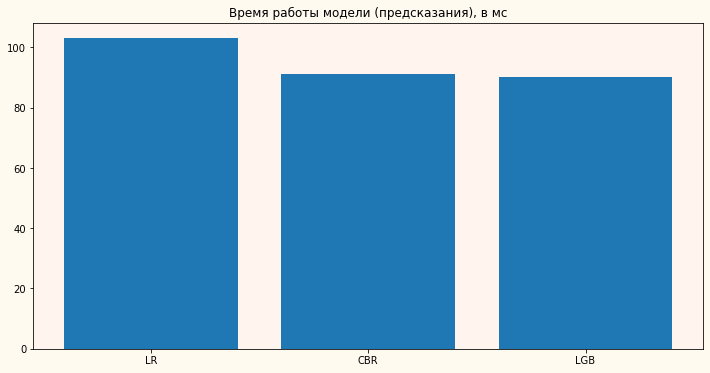

In [64]:
# представим на диаграмме данные по параметру work_time, msec

fig, ax = plt.subplots()

x = df_model['model']
y = df_model['work_time, msec']
ax.bar(x, y)

ax.set_title('Время работы модели (предсказания), в мс')
ax.set_facecolor('seashell')
fig.set_facecolor('floralwhite')
fig.set_figwidth(12)    #  ширина Figure
fig.set_figheight(6)    #  высота Figure

plt.show()

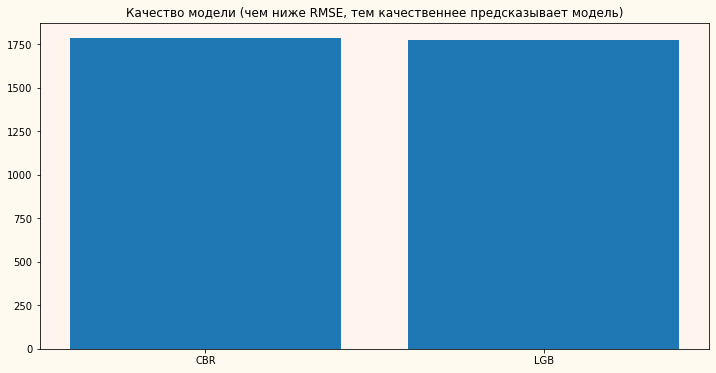

In [65]:
# подготовим датафрейм для анализа качества только CBR и LGBM моделей, т.к. по параметру RMSE модель LR будет не в масштабе
models_CBR_LGBM = [
                   ['CBR', train_time_cbr, work_time_cbr, rmse_cbr], 
                   ['LGB', train_time_lgbm, work_time_lgbm, rmse_lgbm]] 

df_model = pd.DataFrame(models_CBR_LGBM, columns =['model', 'train_time, sec', 'work_time, msec', 'rmse']) 

# представим на диаграмме данные по параметру rmse
fig, ax = plt.subplots()

x = df_model['model']
y = df_model['rmse']
ax.bar(x, y)

ax.set_title('Качество модели (чем ниже RMSE, тем качественнее предсказывает модель)')
ax.set_facecolor('seashell')
fig.set_facecolor('floralwhite')
fig.set_figwidth(12)    #  ширина Figure
fig.set_figheight(6)    #  высота Figure

plt.show()

## Вывод по исследованию

В исследовании были подобраны параметры и обучены 3 модели: LinearRegression, CatBoostRegressor и LightGBM. Самой быстрой и точной оказалась модель LightGBM, незначительно ей уступает в точности CatBoostRegressor, при этом CatBoostRegressor на два порядка дольше всех обучается. Модель LinearRegression не прошла отбор по критерию качества - RMSE превысил максимально допустимое значение в 2500.

**Цель исследования достигнута, а именно создана модель для предсказания рыночной стоимости автомобилей, которая должна иметь высокое качество предсказания (RMSE не более 2500), высокая скорость предсказания и малое время обучения. Такой моделью оказалась LGBMRegressor(learning_rate=0.2, max_depth=7, metric='rmse', objective='regression', verbose=0)